**Andere manier om te kijken naar evaluation, i.p.v terug te splitten en te predicten, nu opgeslagen predicition gebruiken**

In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn.functional as F
import os
import json  # Needed for loading the mappings

# === Define path to the saved run ===
save_path = r"C:\Users\jefva\Documents\Master\Thesis_s2\results\groNLP\GroNLP3\GroNLP3"

# ✅ Load the saved test predictions 
df = pd.read_csv(os.path.join(save_path, "test_predictions.csv"))

# ✅ Recreate logits tensor from the CSV
logits = torch.tensor(df["logits"].apply(eval).tolist())

# ✅ Apply softmax to get prediction probabilities
probabilities = F.softmax(logits, dim=1)

# ✅ Extract raw values
texts = df["text"].tolist()
true_labels_ids = df["true_label"].tolist()
predicted_label_ids = df["predicted_label"].tolist()

# ✅ Convert label IDs to themes using the mappings
with open(os.path.join(save_path, "label_mappings.json"), "r", encoding="utf-8") as f:
    mappings = json.load(f)

theme_to_id = mappings["theme_to_id"]
id_to_theme = {int(k): v for k, v in mappings["id_to_theme"].items()}  # convert keys back to int
unique_themes = mappings["unique_themes"]  # Load the unique themes list


**Unknowns**

In [2]:
# ✅ Dynamic confidence threshold
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 1)
print(f"Dynamic Threshold: {dynamic_threshold:.4f}")

# ✅ Predict with "Unknown" logic
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_id = torch.argmax(probabilities[i]).item()
    question = texts[i]

    if len(question.split()) < 4:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")
    else:
        predicted_labels.append(id_to_theme[pred_id])

# ✅ Convert true labels to theme names
true_labels = [id_to_theme[i] for i in true_labels_ids]

# ✅ Compare and mark correctness
results = []
for true, pred in zip(true_labels, predicted_labels):
    if pred == "Unknown":
        results.append("Unknown")
    elif true == pred:
        results.append("Correct")
    else:
        results.append("Incorrect")

# ✅ Build output DataFrame
output_df = pd.DataFrame({
    "Text": texts,
    "True_Theme": true_labels,
    "Predicted_Theme": predicted_labels,
    "Result": results
})

# ✅ Save it
output_df.to_csv("evaluated_predictions.csv", index=False)



Dynamic Threshold: 0.4567


In [3]:
unknown_count = predicted_labels.count("Unknown")
print(f"Unknown predictions: {unknown_count} / {len(predicted_labels)} ({unknown_count/len(predicted_labels)*100:.2f}%)")


Unknown predictions: 130 / 12915 (1.01%)


**Evaluations**

C:\Users\jefva\AppData\Local\Temp\ipykernel_30856\1732032154.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


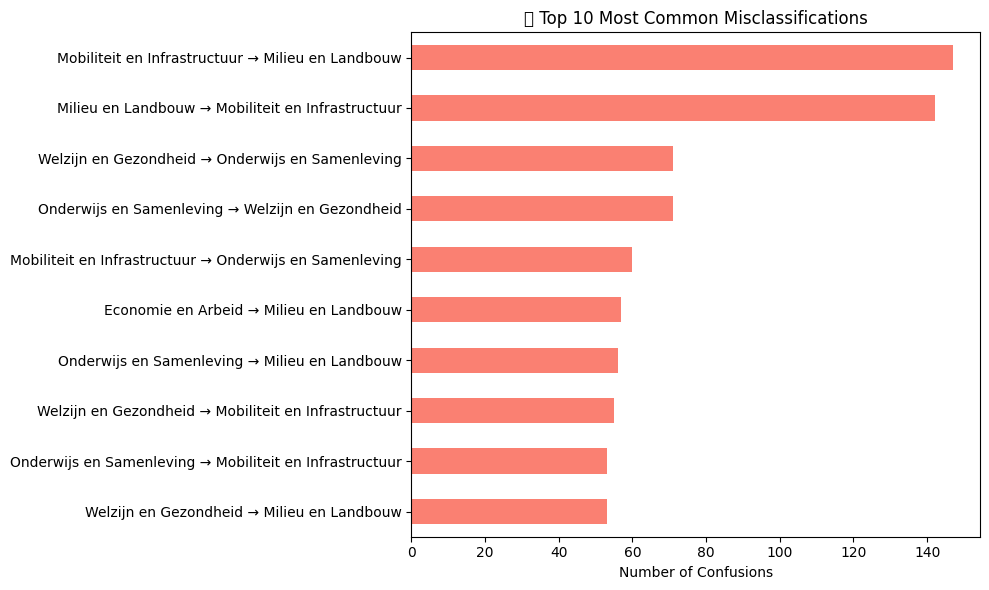

In [4]:
# ✅ Misclassification analysis (excluding Unknowns)
df_misclassified = output_df[
    (output_df["Result"] == "Incorrect") &
    (output_df["Predicted_Theme"] != "Unknown")
]

top_confusions = (
    df_misclassified
    .groupby(["True_Theme", "Predicted_Theme"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

# ✅ Convert MultiIndex to string for plotting
top_confusions_plot = top_confusions.copy()
top_confusions_plot.index = [f"{true} → {pred}" for true, pred in top_confusions_plot.index]

# ✅ Plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_confusions_plot.plot(kind="barh", color="salmon")
plt.xlabel("Number of Confusions")
plt.title("🔍 Top 10 Most Common Misclassifications")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

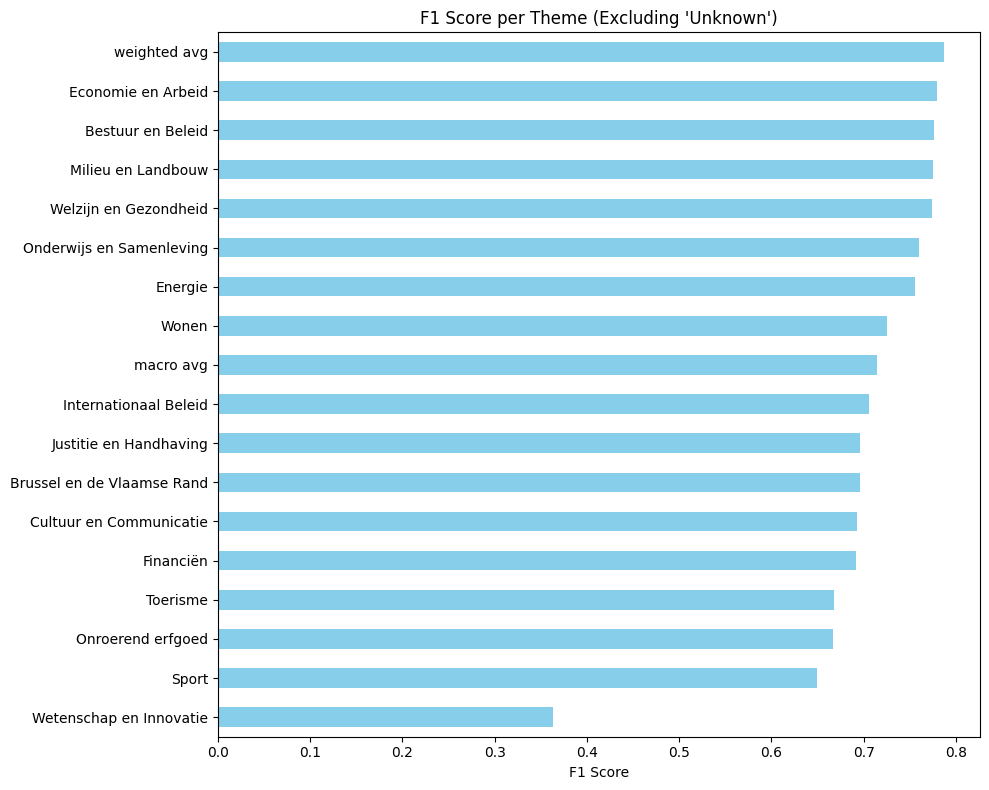

In [5]:
# for clean per-class evaluation, you want to exclude "Unknown" from both True and Predicted values:

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# ✅ Filter out 'Unknown' predictions for proper label matching
filtered_df = output_df[output_df["Predicted_Theme"] != "Unknown"].copy()

# ✅ Encode using only the matching rows
le = LabelEncoder()
true_encoded = le.fit_transform(filtered_df["True_Theme"])
pred_encoded = le.transform(filtered_df["Predicted_Theme"])

# ✅ Get classification report
report = classification_report(
    true_encoded,
    pred_encoded,
    target_names=le.classes_,
    output_dict=True
)

# ✅ Visualize F1 per class
import pandas as pd
import matplotlib.pyplot as plt

df_report = pd.DataFrame(report).transpose().sort_values("f1-score")
df_report[:-3]["f1-score"].plot(kind="barh", figsize=(10, 8), color="skyblue")
plt.title("F1 Score per Theme (Excluding 'Unknown')")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()

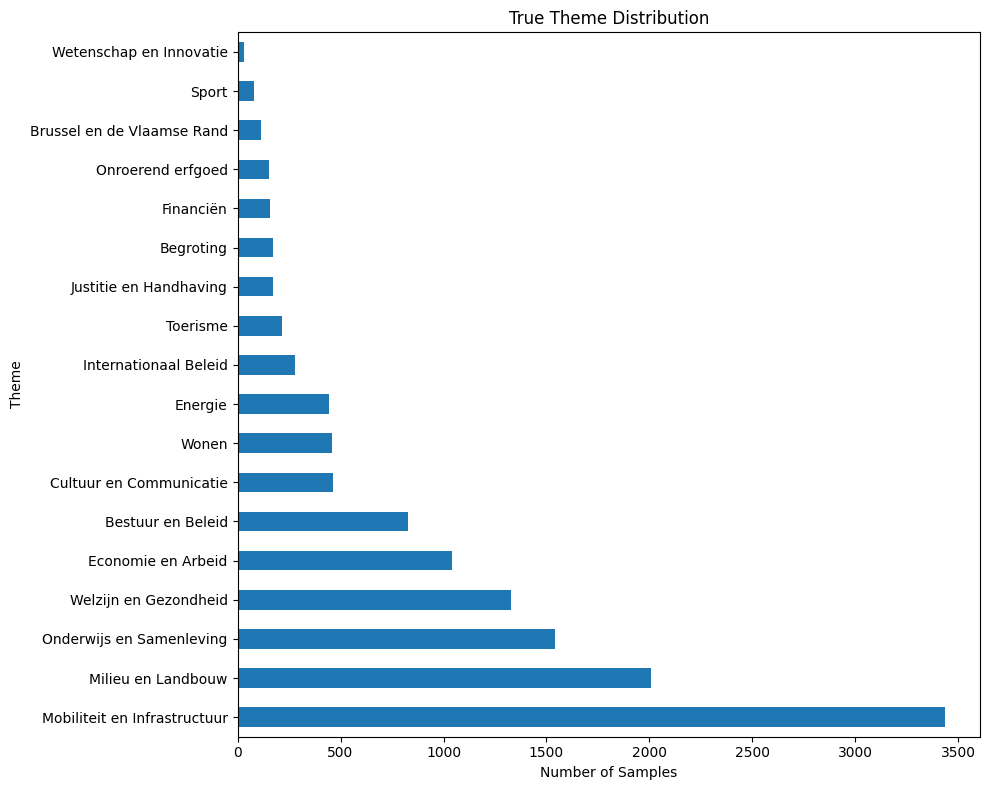

In [6]:
output_df["True_Theme"].value_counts().plot(kind="barh", figsize=(10, 8))

plt.title("True Theme Distribution")
plt.xlabel("Number of Samples")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import classification_report

# Filter out "Unknown"
filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

# Get all unique themes used
all_labels = sorted(set(filtered_true + filtered_pred))

# ✅ Print classification report using theme names directly
print(classification_report(
    filtered_true,
    filtered_pred,
    labels=all_labels,
    target_names=all_labels,
    zero_division=0
))


                              precision    recall  f1-score   support

                   Begroting       0.86      0.75      0.80       168
           Bestuur en Beleid       0.80      0.75      0.78       820
  Brussel en de Vlaamse Rand       0.76      0.65      0.70       110
     Cultuur en Communicatie       0.70      0.69      0.69       458
          Economie en Arbeid       0.78      0.78      0.78      1029
                     Energie       0.78      0.73      0.76       441
                   Financiën       0.68      0.71      0.69       154
       Internationaal Beleid       0.76      0.66      0.71       276
      Justitie en Handhaving       0.76      0.64      0.70       171
          Milieu en Landbouw       0.76      0.80      0.78      1987
Mobiliteit en Infrastructuur       0.87      0.89      0.88      3413
    Onderwijs en Samenleving       0.75      0.77      0.76      1520
           Onroerend erfgoed       0.71      0.63      0.67       152
                   

In [8]:
# ✅ Compute metrics (excluding "Unknown")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

accuracy = accuracy_score(filtered_true, filtered_pred)
precision = precision_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
recall = recall_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
f1 = f1_score(filtered_true, filtered_pred, average="weighted", zero_division=0)

print("\n📊 Evaluation (excluding 'Unknown'):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


📊 Evaluation (excluding 'Unknown'):
Accuracy:  0.7877
Precision: 0.7871
Recall:    0.7877
F1-Score:  0.7868


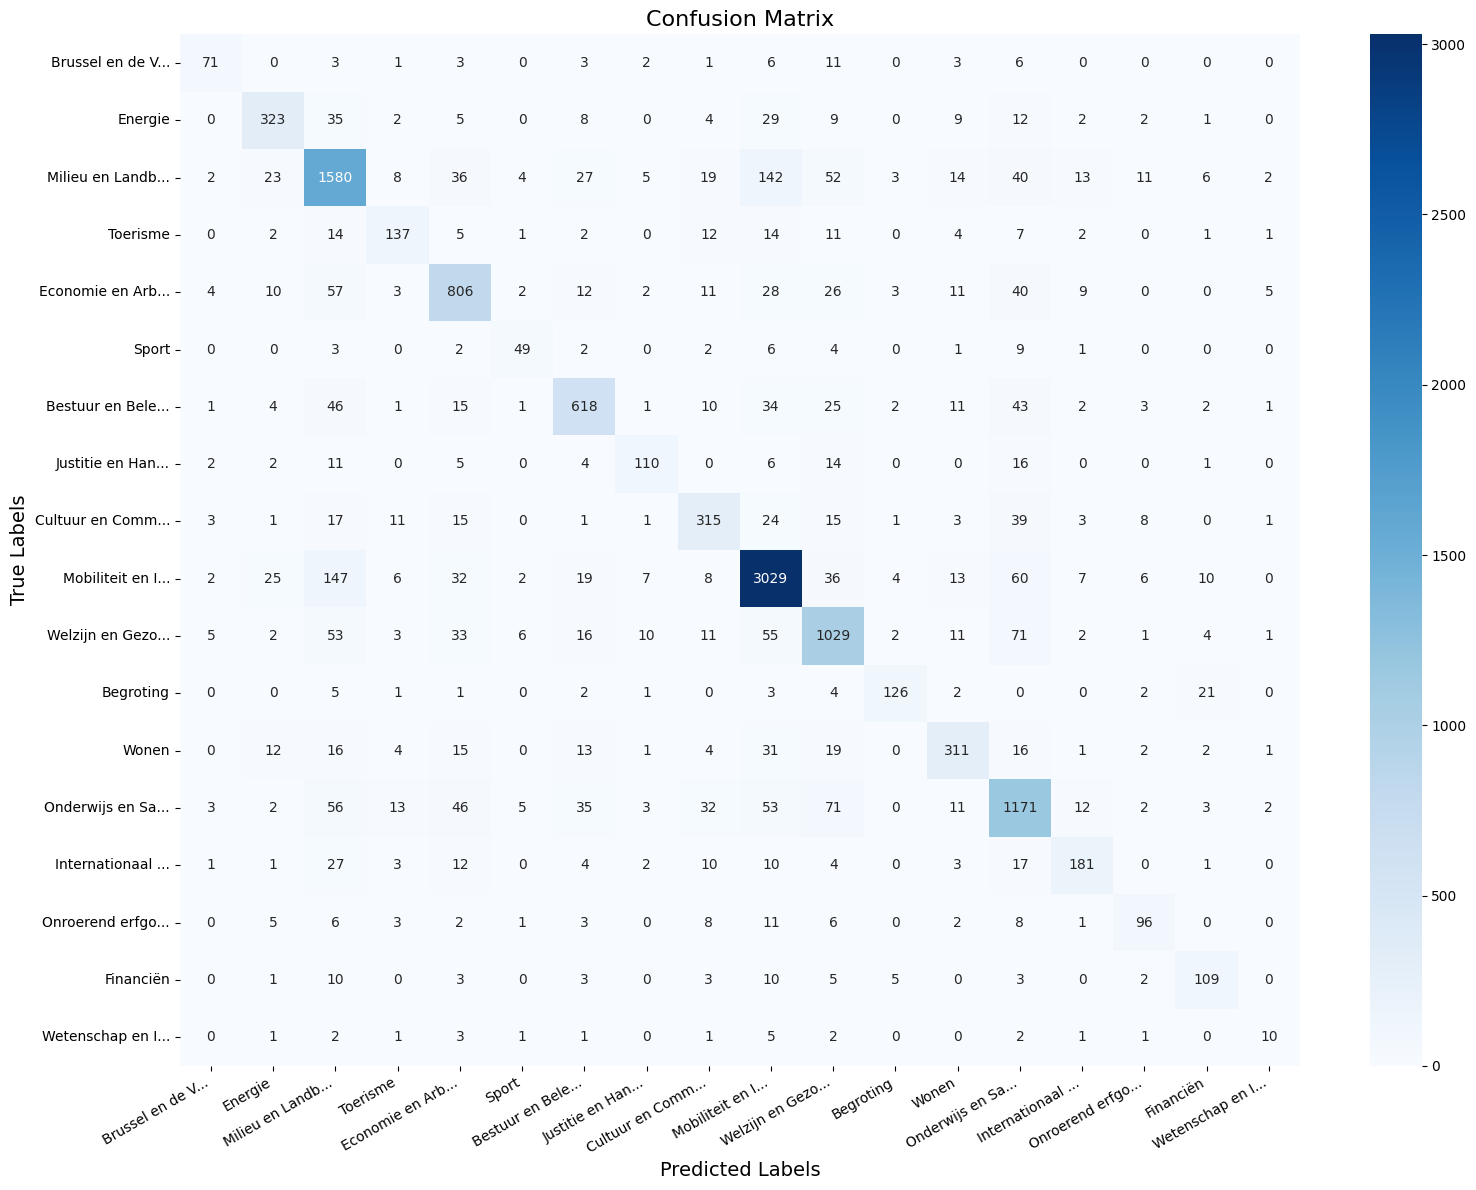

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_themes)

# Shorten labels for better readability (optional)
short_labels = [label[:15] + "..." if len(label) > 15 else label for label in unique_themes]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=short_labels, yticklabels=short_labels, cbar=True)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=30, ha="right", fontsize=10)  # Rotate x-axis labels slightly
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = r"C:\Users\jefva\Documents\Master\Thesis_s2\Code\BERT_Classifiers\mBERT\output\weighted-bert-model"
model_name = "bert-base-multilingual-cased"              # aanpassen naar welk model je wilt evaluaten !!!!
tokenizer = BertTokenizer.from_pretrained(model_name) 
model = BertForSequenceClassification.from_pretrained(model_path).cuda()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([18, 768]) from checkpoint, the shape in current model is torch.Size([41, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([18]) from checkpoint, the shape in current model is torch.Size([41]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

In [ ]:
def get_attention_and_prediction(clean_text):
    """Extracts attention scores and model prediction for a given question."""
    model.config.output_attentions = True  # Ensure attention is enabled

    # Tokenize and move to device
    tokenizer_inputs = tokenizer(clean_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    tokenizer_inputs = {key: val.to(device) for key, val in tokenizer_inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**tokenizer_inputs)

    # Extract attention and logits
    attentions = outputs.attentions
    logits = outputs.logits

    # Get predicted class ID and name
    predicted_class_id = logits.argmax(dim=1).item()
    predicted_class_name = id_to_theme.get(predicted_class_id, "Unknown")

    return attentions, predicted_class_id, predicted_class_name


In [ ]:
test_question = "Hoeveel subsidies zijn toegekend aan bedrijven?"
attention_scores, predicted_class_id, predicted_class_name = get_attention_and_prediction(test_question)

print(f"✅ Model predicted class: {predicted_class_name} (ID: {predicted_class_id})")
print(f"🔍 Total Attention Layers Extracted: {len(attention_scores)}")


In [ ]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load saved predictions
df = pd.read_csv(r"C:\Users\jefva\Documents\Master\Thesis_s2\Code\BERT_Classifiers\mBERT\output\test_predictions.csv")

# Reconstruct logits and true labels
logits = np.array(df["logits"].apply(eval).tolist())
y_true = np.array(df["true_label"].tolist())
y_score = logits  # raw logits

# Get number of classes
n_classes = y_score.shape[1]

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute support (number of samples per class)
support = np.bincount(y_true, minlength=n_classes)
total = support.sum()

# Compute weighted AUC
weighted_auc = sum(roc_auc[i] * support[i] for i in range(n_classes)) / total
print(f"✅ Weighted ROC AUC: {weighted_auc:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (Weighted AUC = {:.2f})".format(weighted_auc))
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


# Sample 2000 rows for UMAP
sample_df = df[["text", "true_label"]].sample(n=min(2000, len(df)), random_state=42)
sample_df.rename(columns={"text": "clean_text", "true_label": "theme_id"}, inplace=True)

# Function to get CLS embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.base_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.cpu().squeeze().numpy()

# Generate embeddings
embeddings = []
print("Generating fine-tuned embeddings (from test set)...")
for text in tqdm(sample_df["clean_text"]):
    emb = get_cls_embedding(text)
    embeddings.append(emb)

# Run UMAP
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Encode labels for plotting
le = LabelEncoder()
labels = le.fit_transform(sample_df["theme_id"])

# Plot UMAP
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
plt.title("UMAP of mBERT Embeddings (After Fine-tuning on Test Set)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cb = plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Theme")
tick_labels = [id_to_theme[i] for i in le.classes_]
cb.ax.set_yticklabels(tick_labels)
plt.clim(-0.5, len(le.classes_)-0.5)
plt.grid(True)
plt.tight_layout()
plt.show()